In [1]:
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
from astropy.io import fits

In [3]:
from astropy.coordinates import SkyCoord

In [4]:
import astropy.wcs.wcs as wcs
import matplotlib.pyplot as plt

In [5]:
from collections import OrderedDict

# Initialize data directory

In [6]:
path = "../../Data/"

In [7]:
!ls $path/Subaru_data

G.cat                      MACS1752.png               RGB_Subaru_2d.fits
G.fits                     R.cat                      R_cropped.fits
G.fits.fz                  R.fits                     Rshape_processed.h5
G_cropped.fits             R.fits.fz                  crop_fits.md
I.cat                      R.shape                    crop_fits.sh
I.fits                     RGB_Subaru                 p358Dust.fits
I.fits.fz                  RGB_Subaru.fits            preprocessed_subaru_cat.h5
I_cropped.fits             RGB_Subaru.png


# Data massaging

-[ ] combine table so we don't have to deal with several copies of the table  
-[ ] clean table according to the cuts in the Rshape catalog  
-[ ] transform image coords to WCS coords



In [8]:
dataPath = path + "Subaru_data/" 

See how to convert FITS record array to pandas dataframe for easy manipulation
in `preprocess.py`

In [9]:
bands = ["I", "R", "G"]

In [41]:
cats = OrderedDict({})
wcs_dict = OrderedDict({})
df_dict = OrderedDict({})
for band in ["I", "R", "G"]:
    cats[band] = fits.open(dataPath + "{0}.cat".format(band))
    # don't need wcs_dict if no wcs coord transformation is done
    # wcs_dict[band] = wcs.WCS(cats[band][0].header) 
    df_dict[band] = pd.read_hdf(dataPath + "preprocessed_subaru_cat.h5", 
                                band + "_data")
    df_dict[band].columns = ["{0}band_".format(band) + col 
                             for col in df_dict[band].columns]

## load Rshape catalog

In [57]:
Rshape = fits.open(dataPath + "R.shape")
Rshapes = pd.DataFrame(Rshape[1].data.tolist(), 
                       columns=Rshape[1].data.dtype.names)

## see if wcs_coords tells us if the objects are the same across catalogs

In [43]:
wcs_keys = ['X_WORLD', u'Y_WORLD']

In [47]:
np.sum(df_dict["I"][["Iband_" + k for k in wcs_keys]] - 
       df_dict["G"][["Gband_" + k for k in wcs_keys]])

Gband_X_WORLD    0
Gband_Y_WORLD    0
Iband_X_WORLD    0
Iband_Y_WORLD    0
dtype: float64

In [49]:
np.sum(df_dict["I"][["Iband_" + k for k in wcs_keys]] - 
       df_dict["R"][["Rband_" + k for k in wcs_keys]])

Iband_X_WORLD    0
Iband_Y_WORLD    0
Rband_X_WORLD    0
Rband_Y_WORLD    0
dtype: float64

seems like the coords already show objects in the correct order

In [53]:
df_dict["I"][["Iband_" + k for k in wcs_keys]].iloc[0]

Iband_X_WORLD    268.146518
Iband_Y_WORLD     44.363666
Name: 0, dtype: float64

In [55]:
df_dict["G"][["Gband_" + k for k in wcs_keys]].iloc[0]

Gband_X_WORLD    268.146518
Gband_Y_WORLD     44.363666
Name: 0, dtype: float64

In [56]:
df_dict["R"][["Rband_" + k for k in wcs_keys]].iloc[0]

Rband_X_WORLD    268.146518
Rband_Y_WORLD     44.363666
Name: 0, dtype: float64

In [67]:
for band in ["R", "G", "I"]:
    print df_dict[band].shape[0]

100680
100680
100680


seems like it is true that the objects are already aligned 

In [75]:
np.sum(df_dict["R"]["Rband_FLUX_RADIUS"] - Rshapes["FLUX_RADIUS"])

0.0

In [104]:
combined_cat = pd.concat([Rshapes, df_dict["R"], df_dict["I"], df_dict["G"]], 
                         axis=1)

# save combined cat before preprocessing

In [105]:
combined_cat.to_hdf(dataPath + "combined_cat.h5", "preprocessed_df")

# apply the same cuts as the shape catalog 

Questions to ask James about: 

* Any ellipticities DE greater than 0.3 should be trashed
* A, B, THETA are shape parameters 
* STATUS are sextractor internal flags


In [109]:
combined_cat = combined_cat[combined_cat.DE < 0.3]

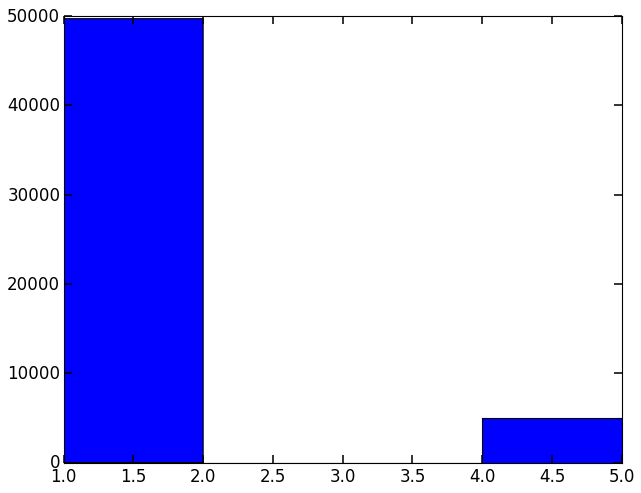

In [84]:
_ = plt.hist(np.array(combined_cat.STATUS), bins=4)

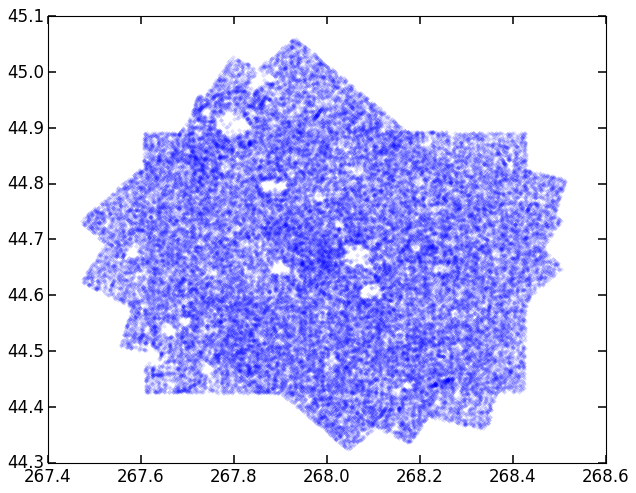

In [86]:
plt.plot(combined_cat.RA, combined_cat.DEC, '.', alpha=0.1)

# Reduce the number of data points
by cutting out some of the outer regions 

recalculate where to cut ...
ref: van Weeren 2012 Fig. 1

# cut away the stars 

In [110]:
star_keys = [k for k in combined_cat.keys() if "STAR" in k]

In [111]:
star_keys

['Rband_CLASS_STAR', 'Iband_CLASS_STAR', 'Gband_CLASS_STAR']

according to http://www.na.astro.it/oacdf/OACDFPAP/node16.html,   
if `CLASS_STAR > 0.8` and `MAG < 20` i.e. not too faint,    
we can assume the object is a star 


we only discard objects if they are likely to be stars in all 3 bands,   
i.e. `CLASS_STAR > 0.8` in all three bands.  

In [112]:
star_mask = np.sum(combined_cat[star_keys] > 0.8, axis=1) != 3

In [113]:
len(star_mask)

54724

In [114]:
combined_cat = combined_cat[star_mask]

# Area cut! 

In [115]:
lower_left = SkyCoord("17h52m40s", "44d35m30s")
upper_right = SkyCoord("17h51m40s", "44d45m30s")

In [116]:
ra_upper = lower_left.ra.deg
ra_lower = upper_right.ra.deg
dec_lower = lower_left.dec.deg
dec_upper = upper_right.dec.deg

print ra_lower, ra_upper
print dec_lower, dec_upper

267.916666667 268.166666667
44.5916666667 44.7583333333


In [117]:
combined_cat = combined_cat[np.logical_and(
        combined_cat.Rband_X_WORLD > ra_lower, 
        combined_cat.Rband_X_WORLD < ra_upper)]
combined_cat = combined_cat[np.logical_and(
        combined_cat.Rband_Y_WORLD > dec_lower,
        combined_cat.Rband_Y_WORLD < dec_upper)]

In [118]:
combined_cat.shape[0]

5215

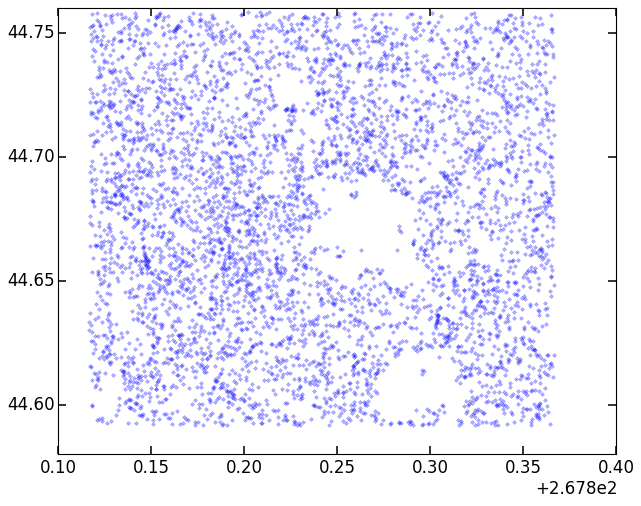

In [119]:
plt.plot(combined_cat.Rband_X_WORLD, 
         combined_cat.Rband_Y_WORLD, '.', alpha=0.3)

In [120]:
combined_cat.to_hdf(dataPath + "combined_cat.h5", 
                    "processed_df_w_shape_n_star_cuts")